# Continuous Optimisation HW2

In [1]:
# Imports
import numpy as np
import scipy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from tqdm import tqdm
from scipy.io import loadmat
import time



data = loadmat('data.mat')
data_toy = loadmat('data-toy.mat')

# Question 1
Implement phi(x, P), bigphi(X, P), f(X, P, y).

In [2]:
# Question 1
# Vectorise all the functions

def h(x: np.ndarray) -> float:
    """
    Gaussian filter

    :x: np.ndarray[(1, 2)]
    :returns: float
    """
    global sigmasquared
    return np.e**(-np.inner(x, x)/sigmasquared)  # Always take sigma = 0.1


def phi(x,P):
    """
    Calculate contribution of each 'true' star to observed image
    
    :x: np.ndarray[(2, 1)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(n**2, 1)]
    """
    global sigmasquared
    return (np.e**((-1/sigmasquared)*np.sum((P.T-x.T)**2,axis=1))).reshape((-1, 1), order="F")


def bigphi(X, P):
    """
    Calculate image observed, based on K-star positions X
    
    :X: np.ndarray[(2, K)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(n**2, 1)]
    """
    global K, n
    X = X.flatten(order="F")
    #non-vectorised code just in case we need it
    bigphi = np.zeros((n**2, 1))
    for i in range(K):
        bigphi += phi(X[2*i:2*i+2], P)
    #return phi(X, P)
    return bigphi


def  f(X, P, y):
    """
    Calculate squared error of estimate bigphi(X)
    
    :X: np.ndarray[(2, K)]
    :P: np.ndarray[(2, n**2)]
    :y: np.ndarray[(n**2, 1)]
    :returns: float
    """
    global n
    return (1/(2*n**2)) * np.linalg.norm(bigphi(X, P)-y)**2


# Question 2

We see that $f$ is not convex. There are clear local maxima which cannot occur if $f$ were convex.

/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_48905/1433370158.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = float(data['sigma'])


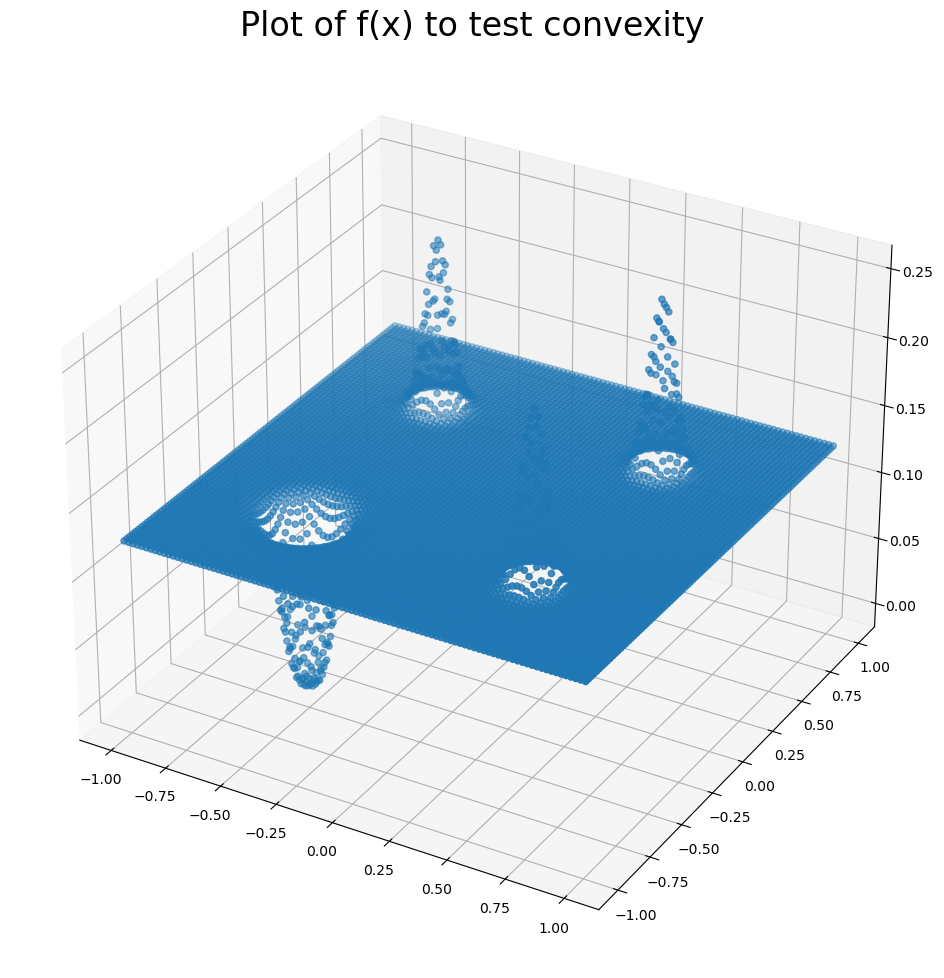

In [3]:
K = 1
n = 2
sigma = float(data['sigma'])
sigmasquared = sigma**2
true_positions = np.array([[0], [0]])
positions = np.array([[0.5, 0.5], [-0.5, 0.5], [-0.5, -0.5], [0.5, -0.5]]).T
y = np.array([[0], [0], [1], [0]])
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

x_vals = np.linspace(-1, 1, 100)
y_vals = np.linspace(-1, 1, 100)
x_vals, y_vals = np.meshgrid(x_vals, y_vals)
grid = np.array([x_vals, y_vals]).reshape((2, 100**2), order="F")
z_vals = np.zeros((1, 10000))
for i in range(10000):
    z_vals[0, i] = f(grid[:, i].reshape((2, 1), order="F"), positions, y)
z_vals = z_vals.reshape((100, 100), order="F")
ax.scatter(x_vals, y_vals, z_vals)

plt.title('Plot of f(x) to test convexity', fontsize=24)
plt.show()
#plt.show()

# Question 3

$ \phi(x) = $ $\begin{bmatrix}
h(p_1 - x) \\
\vdots \\
h(p_{n^2} - x)
\end{bmatrix} $
$=$ $\begin{bmatrix}
e^{-\frac{\|p_1 - x\|^2}{\sigma^2}} \\
\vdots \\
e^{-\frac{\|p_{n^2} - x\|^2}{\sigma^2}}
\end{bmatrix}$


$D\phi(x) = $ $\begin{bmatrix}
\frac{\partial \phi_1}{\partial x_1} & \frac{\partial \phi_1}{\partial x_2} \\
\frac{\partial \phi_2}{\partial x_1} & \frac{\partial \phi_2}{\partial x_2} \\
\vdots & \vdots \\
\frac{\partial \phi_{n^2}}{\partial x_1} & \frac{\partial \phi_{n^2}}{\partial x_2}
\end{bmatrix}$ $=$ $ \begin{bmatrix}
\frac{2}{\sigma^2} (p_{1,1} - x_1) e^{-\frac{\|p_{1} - x\|^2}{\sigma^2}} & \frac{2}{\sigma^2} (p_{1,2} - x_2) e^{-\frac{\|p_{1} - x\|^2}{\sigma^2}} \\
\vdots & \vdots \\
\frac{2}{\sigma^2} (p_{n^2,1} - x_1) e^{-\frac{\|p_{n^2} - x\|^2}{\sigma^2}} & \frac{2}{\sigma^2} (p_{n^2,2} - x_2) e^{-\frac{\|p_{n^2} - x\|^2}{\sigma^2}}
\end{bmatrix}$

$D\phi(x)[u] =$ $ \begin{bmatrix}
\frac{2}{\sigma^2} (p_{1,1} - x_1) e^{-\frac{\|p_{1} - x\|^2}{\sigma^2}} & \frac{2}{\sigma^2} (p_{1,2} - x_2) e^{-\frac{\|p_{1} - x\|^2}{\sigma^2}} \\
\vdots & \vdots \\
\frac{2}{\sigma^2} (p_{n^2,1} - x_1) e^{-\frac{\|p_{n^2} - x\|^2}{\sigma^2}} & \frac{2}{\sigma^2} (p_{n^2,2} - x_2) e^{-\frac{\|p_{n^2} - x\|^2}{\sigma^2}}
\end{bmatrix}$ $\begin{bmatrix} u_1 \\ u_2 \end{bmatrix}$


$D\phi(x)[u] = \begin{bmatrix} \frac{2}{\sigma^2} \left[ (p_{1,1} - x_1) u_1 + (p_{1,2} - x_2) u_2 \right] e^{-\frac{\|p_1 - x\|^2}{\sigma^2}} \\ \frac{2}{\sigma^2} \left[ (p_{2,1} - x_1) u_1 + (p_{2,2} - x_2) u_2 \right] e^{-\frac{\|p_2 - x\|^2}{\sigma^2}} \\ \vdots \\ \frac{2}{\sigma^2} \left[ (p_{n^2,1} - x_1) u_1 + (p_{n^2,2} - x_2) u_2 \right] e^{-\frac{\|p_{n^2} - x\|^2}{\sigma^2}} \end{bmatrix}$


# Question 4
The adjoint of $D\phi(x): \mathbb{R}^2 \to \mathbb{R}^{n^2}$ is $ A^{\star}$ such that: 

$
\langle v, D\phi(x)[u] \rangle = \langle A^{\star} v, u \rangle \quad \forall v,u \in \mathbb{R}^2
$

which is equivalent to:

$
v^T D\phi(x) u = v^T (A^{\star})^T u \quad \forall v,u\in \mathbb{R}^2
$

equivalent to:

$
A^{\star} = D\phi(x)^T
$

# Question 5

Define  $g_1 : \mathbb{R}^{n^2} \rightarrow \mathbb{R}$ by
$
g_1(x) = \| x \|^2
$

The Jacobian of $ g_1 $ is $ Dg_1(x) = 2x^T $.

Then $ f(X) = \frac{1}{2n^2} \| \Phi(X) - y \|^2 $ $= \frac{1}{2n^2} g_1(\Phi(X) - y)$ 


$
Df(X) = \frac{1}{2n^2} D[g_1 \circ (\Phi(X) - y)]  = \frac{1}{2n^2} \left[ Dg_1(\Phi(X) - y) D(\Phi(X)-y) \right]
$
$
= \frac{1}{n^2} (\Phi(X) - y)^T D\Phi(X)
$

And using the chain rule we have:

$$ Df(x)[v] = \frac{1}{n^2}< \Phi(x) - y,D \Phi(x)[v] > = \frac{1}{n^2}<(D\Phi(x))^*[\Phi(x) - y],v> $$

$$ \nabla f(x) = \frac{(D\Phi(x))^*[\Phi(x) - y]}{n^2} $$


To be able to keep the Jacobians as square matrices and not 3-dim tensors, we flatten X:

Going from $ X = \begin{bmatrix} X_{11} & \dots & X_{1K} \\ X_{21} & \dots & X_{2K} \end{bmatrix} \in \mathbb{R}^{2 \times K} $

to $X = \begin{bmatrix} X_{11} & X_{21} & X_{12} & X_{22} & \dots & X_{1K} & X_{2K} \end{bmatrix} \in \mathbb{R}^{2K} $.

And so we have:

$
D\Phi(X) = \frac{\partial \Phi(X)}{\partial X} = \begin{bmatrix} \frac{\partial}{\partial X_{11}} \sum_{k=1}^{K}\varphi(X_{11}, X_{21}) \; \frac{\partial}{\partial X_{21}} \sum_{k=1}^{K}\varphi(X_{11}, X_{21}) & \dots &  \frac{\partial}{\partial X_{1K}} \sum_{k=1}^{K}\varphi(X_{1K}, X_{2K}) \; \frac{\partial}{\partial X_{2K}} \sum_{k=1}^{K}\varphi(X_{1K}, X_{2K}) \end{bmatrix}
$

$
= \begin{bmatrix} \frac{\partial}{\partial X_{11}} \varphi(X_{11}, X_{21}) \frac{\partial}{\partial X_{21}} \varphi(X_{11}, X_{21}) & \dots & \frac{\partial}{\partial X_{1K}} \varphi(X_{1K}, X_{2K}) \frac{\partial}{\partial X_{2K}} \varphi(X_{1K}, X_{2K}) \end{bmatrix} 
$

$
= \begin{bmatrix} D\varphi(X_{11}, X_{21}) & \dots & D\varphi(X_{1K}, X_{2K}) \end{bmatrix}   \in \mathbb{R}^{n^2 \times 2K}
$

# Question 6.1

In [4]:
def d_phi_i_0(x,p_i):
    """
    Computes value of cell i_0 of jacobian of phi
    
    :x: np.ndarray[(2, 1)]
    :p_i: np.ndarray[(2, 1)]
    :returns: float
    """
    return (2/sigmasquared)*(p_i[0]-x[0])*np.e**((-1/sigmasquared)*np.inner(p_i-x,p_i-x))

def d_phi_i_1(x,p_i):
    """
    Computes value of cell i_1 of jacobian of phi
    
    :x: np.ndarray[(2, 1)]
    :p_i: np.ndarray[(2, 1)]
    :returns: float
    """
    return (2/sigmasquared)*(p_i[1]-x[1])*np.e**((-1/sigmasquared)*np.inner(p_i-x,p_i-x))
    
def d_phi(x, P):
    """
    Computes the jacobian of small phi

    :x: np.ndarray[(1, 2)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(n**2, 2)]
    """
    # Subtract x from each column of P
    diff = P.T - x
    # Compute the squared differences
    squared_diff = np.sum(diff**2, axis=1)
    # Compute the exponential term for all elements at once
    exp_term = np.exp((-1 / sigmasquared) * squared_diff)
    # Compute the values for d_phi_i_0 and d_phi_i_1 using vectorized operations
    """can we just do the multiplication of the matrix directly here?"""
    d_phi_0 = (2 / sigmasquared) * diff[:, 0] * exp_term
    d_phi_1 = (2 / sigmasquared) * diff[:, 1] * exp_term
    # Stack the results to form the final array
    d_phi = np.stack((d_phi_0, d_phi_1), axis=1)
    return d_phi

def d_big_phi(X,P):
    """
    Computes the jacobian of big phi

    :X: np.ndarray[(1, 2K)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(n**2, 2K)]
    """
    d_big_phi = np.zeros((n**2,2*K))
    for i in range(K):
        d_big_phi[0:n**2,2*i:2*i+2] = d_phi(X[2*i:2*i+2].T,P)
    return d_big_phi

#compute gradient of f
def grad_f(X,P):
    """
    Computes the gradient of f

    :X: np.ndarray[(1, 2K)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(2K, 1)]
    """
    return ((1/n**2)*(bigphi(X,P)-y).T@d_big_phi(X,P)).T

# Question 6.2

/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_48905/1017835024.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K = int(data['K'])
/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_48905/1017835024.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d = int(data['d'])
/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_48905/1017835024.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(data['n'])
/var/folders/zt/35xtgbfd7292

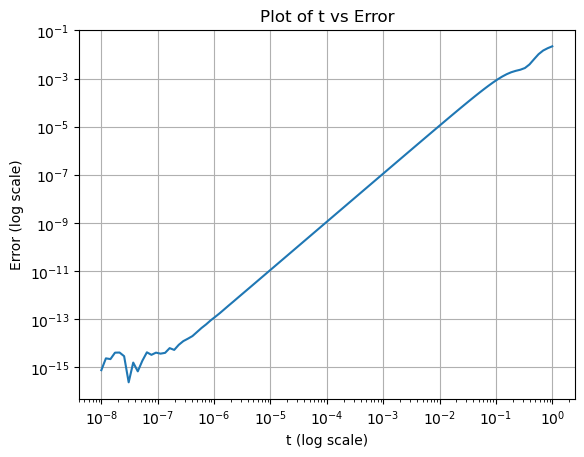

In [5]:
#initialising variables from data (set)
K = int(data['K'])
P = data['P']
X0 = data['X0']
d = int(data['d'])
delta_0 = data['delta_0']
delta_bar = data['delta_bar']
n = int(data['n'])
sigma = float(data['sigma'])
y = data['y'].flatten(order='F').reshape((n**2,1), order="F")

#check that the gradient is correct using taylor expansion
# f(x+tv)= f(x) + t<v,grad_f(x)> + O(t^2)

# Generate a random point and a random direction
theta = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape((d*K,1), order="F")
v = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape((d*K,1), order="F")
v = v / np.linalg.norm(v)

## Check the gradient 
def checkgradient(f,grad_f, theta,v):
    #logspace of t values
    t=np.logspace(-8, 0, num=100)
    #intialise error to 0
    error = np.zeros_like(t)
    #pre-calculae f_lambda and f_lambda_grad to use in for loop
    f_lambda = f(theta,P,y)
    f_lambda_grad = grad_f(theta,P)
    #compute the error at each t
    for i in tqdm(range(100)):
        error[i] = np.abs( f(theta+(t[i]*v),P,y)-f_lambda-(t[i]*v.T@f_lambda_grad) )
        
    #plot the graph of error vs t
    plt.loglog(t,error)
    plt.xlabel('t (log scale)')
    plt.ylabel('Error (log scale)')
    plt.title('Plot of t vs Error')
    plt.grid()
    plt.show
checkgradient(f,grad_f,theta,v)

# Question 7

## Computing the Hessian 

First we re-derive the gradient of f using the chain rule:

$$ f(x) = \frac{1}{2n^2}||\Phi(x) - y ||^2$$

$$ Df(x)[v] = \frac{1}{n^2}< \Phi(x) - y,D \Phi(x)[v] > = \frac{1}{n^2}<(D\Phi(x))^*[\Phi(x) - y],v> $$

$$ \nabla f(x) = \frac{(D\Phi(x))^*[\Phi(x) - y]}{n^2} $$

Then, using the above calculations, we can calculate the hessian using the product rule:

$$ \nabla^2 f(x)[v] = \frac{1}{n^2}[(D(D\Phi(x))[v]^*)[\Phi(x)-y]+D\Phi(x)^*[D\Phi(x)[v]]] $$


---
For the calculation of $D(D\Phi(X))[v]$

$
\Phi : \mathbb{R}^{2K} \rightarrow \mathbb{R}^{n^2}
$

$
J := D\Phi : \mathbb{R}^{2K} \rightarrow \mathbb{R}^{n^{2} \times 2K}
$

$
\varphi : \mathbb{R}^2 \rightarrow \mathbb{R}^{n^2}
$
$
D\varphi : \mathbb{R}^2 \rightarrow \mathbb{R}^{n^2 \times 2}
$

We define:

$
g_1(\vec{x})(\vec{p}) = \frac{2}{\sigma^2} (\vec{p}, x_1) e^{-\frac{1}{\sigma^2} \| \vec{p} - x_1 \|^2}
$

$
g_2(\vec{x})(\vec{p}) = \frac{2}{\sigma^2} (\vec{p}, x_2) e^{-\frac{1}{\sigma^2} \| \vec{p} - x_2 \|^2}
$

Their jacobians being: 

$
Dg_1(\vec{x})(\vec{p}) = \begin{bmatrix} \frac{\partial}{\partial x_1} g_1(\vec{x})(\vec{p}) & \frac{\partial}{\partial x_2} g_1(\vec{x})(\vec{p}) \end{bmatrix}
$

$
= \begin{bmatrix} \frac{4}{\sigma^4} (p_1-x_1)^2  e^{-\frac{1}{\sigma^2} \| p - x \|^2} - \frac{2}{\sigma^2}e^{-\frac{1}{\sigma^2} \| p - x \|^2} \;\; \frac{4}{\sigma^4} (p_1-x_1)(p_2-x_2)  e^{-\frac{1}{\sigma^2} \| p - x \|^2}  \end{bmatrix}
$

$
Dg_2(\vec{x})(\vec{p}) = \begin{bmatrix} \frac{\partial}{\partial x_1} g_2(\vec{x})(\vec{p}) & \frac{\partial}{\partial x_2} g_2(\vec{x})(\vec{p}) \end{bmatrix}
$

$
= \begin{bmatrix}  \frac{4}{\sigma^4} (p_1-x_1)(p_2-x_2)  e^{-\frac{1}{\sigma^2} \| p - x \|^2} \;\; \frac{4}{\sigma^4} (p_2-x_2)^2  e^{-\frac{1}{\sigma^2} \| p - x \|^2} - \frac{2}{\sigma^2}e^{-\frac{1}{\sigma^2} \| p - x \|^2}  \end{bmatrix}
$

---
$
D(D\Phi(X))[v] = DJ(X)[v]
$

$
= \lim_{t \to 0} \frac{J(X + tv) - J(X)}{t}
$

$
= \lim_{t \to 0} \frac{D\Phi(X + t V) - D\Phi(X)}{t}
$

$
= \begin{bmatrix} \lim_{t \to 0} \frac{D\varphi(x_1 + tv_1) - D\varphi(x_1)}{t} \;\; \ldots \;\; \lim_{t \to 0} \frac{D\varphi(x_K + tv_K) - D\varphi(x_K)}{t} \end{bmatrix}
$

$
= \begin{bmatrix}
    \begin{bmatrix} Dg_1(x_1)(p_1)[v_1] & Dg_2(x_1)(p_1)[v_1] \\ \vdots & \vdots \\ Dg_1(x_1)(p_n)[v_1] & Dg_2(x_1)(p_n)[v_1] \end{bmatrix} &
    \cdots &
    \begin{bmatrix} Dg_1(x_K)(p_1)[v_K] & Dg_2(x_K)(p_1)[v_K] \\ \vdots & \vdots \\ Dg_1(x_K)(p_n)[v_K] & Dg_2(x_K)(p_n)[v_K] \end{bmatrix}
\end{bmatrix}
$




In [6]:
def d_g(x,P,v):
    #subtract x from each column of P
    diff = P.T-x
    # Compute the squared differences
    squared_diff = diff**2
    norm_squared = np.sum(diff**2, axis=1)
    # Compute the exponential term for all elements at once
    a_1 = np.exp((-1 / sigmasquared) * norm_squared)*(2 / sigmasquared)**2
    # Compute the values for d_phi_i_0 and d_phi_i_1 using vectorized operations
    d_g_1_0 = a_1 *(v[0]*(squared_diff[:,0]-(sigmasquared/2))+v[1]*diff[:,0]*diff[:,1])
    d_g_1_1 = a_1 *(v[1]*(squared_diff[:,1]-(sigmasquared/2))+v[0]*diff[:,0]*diff[:,1])
    # Stack the results to form the final array
    d_g = np.stack((d_g_1_0, d_g_1_1), axis=1)
    return d_g
    


def d_d_phi(X, P, V):
    """
    Compute the directional derivative of the Jacobian of phi at x in the direction v.

    :param X: np.ndarray[(1, 2K)] "position of a stat"
    :param P: np.ndarray[(2, n**2)] "pixel positions"
    :param V: np.ndarray[(1, 2K)] "vector direction of change in star position"
    :returns: np.ndarray[(n**2, 2K)]
    """
    d_d_phi = np.zeros((n**2,2*K))
    for i in range(K):
            d_d_phi[0:n**2,2*i:2*i+2] = d_g(X[2*i:2*i+2].T,P,V[2*i:2*i+2])
    return d_d_phi
    


def hessian_f(X,V):
    """
    Compute the Hessian of f at X in the direction v.
    
    :param X: np.ndarray[(1, 2K)] "position of K stars"
    :param P: np.ndarray[(2, n**2)] "pixel positions"
    :param y: np.ndarray[(n**2, 1)] "actual image detected, y = Phi(X_true)" remember we want to find X_true
    :param v: np.ndarray[(2, K)] "direction at which hessian is taken" 
    :returns: np.ndarray[(2*K, 1)]
    """
    # Compute intermediate terms
    phi_X = bigphi(X, P) - y  # (n**2, 1)
    d_big_phi_X = d_big_phi(X, P)  # (n**2, 2*K)
    d_big_phi_X_v = d_big_phi_X @ V  # directional derivative of big_phi in direction v

    # Compute each term in the Hessian formula

    term1 = d_d_phi(X, P, V).T @ phi_X 
    term2 = d_big_phi_X.T @ d_big_phi_X_v 

    hessian = (1 / n**2) * (term1 + term2)
    return hessian



# Question 8
From $ t = 10^{-8} $ to $ 10^{-5} $, the line deviates from being straight, likely due to round-off errors caused by the small values of $ t $ and the error. This is not a concern, as the trust-region method can handle inaccuracies in the Hessian approximation near the point of interest by expanding the trust region or radius as needed.

Beyond this range, the graph forms a straight line with a slope of 3, confirming that the Hessian calculation is correct. 

We also observe a slight bump around $ t = 10^{-1} $, which can vary depending on the randomized values of $ \theta $ and $ v $. This is likely due to $ f $ being very small at this point, where the function approaches 0. However, since the values are small, this deviation is not problematic.

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_48905/2432862050.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error[i] = np.abs(f(theta+(t[i]*v),P,y)-f_lambda-(t[i]*v.T@f_lambda_grad)- ((t[i]**2)/2)*v.T@f_lambda_hess_v)
100%|██████████| 100/100 [00:08<00:00, 11.80it/s]


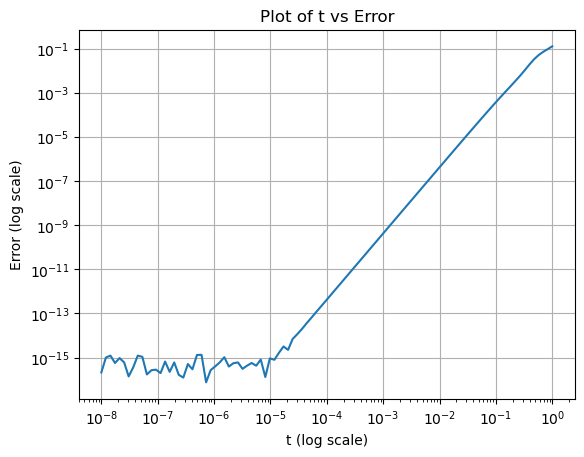

In [7]:
# Generate a random point and a random direction
theta = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape((d*K,1), order="F")
v = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape((d*K,1), order="F")
v = v / np.linalg.norm(v)

## Check the hessian 
def checkhessian(f,grad_f,hessian_f,theta,v):
    #logspace of t values
    t=np.logspace(-8, 0, num=100)
    #intialise error to 0
    error = np.zeros_like(t)
    #pre-calculae f_lambda and f_lambda_grad to use in for loop
    f_lambda = f(theta,P,y)
    f_lambda_grad = grad_f(theta,P)
    f_lambda_hess_v = hessian_f(theta,v)
    #compute the error at each t
    for i in tqdm(range(100)):
        error[i] = np.abs(f(theta+(t[i]*v),P,y)-f_lambda-(t[i]*v.T@f_lambda_grad)- ((t[i]**2)/2)*v.T@f_lambda_hess_v)
        
    #plot the graph of error vs t
    plt.loglog(t,error)
    plt.xlabel('t (log scale)')
    plt.ylabel('Error (log scale)')
    plt.title('Plot of t vs Error')
    plt.grid()
    plt.show
checkhessian(f,grad_f,hessian_f,theta,v)

# Question 9

In [8]:
def truncated_conjugate_gradient(b: np.array, radius: float, x0) -> tuple:
    """
    Solve the trust-region subproblem using the Truncated Conjugate Gradient (tCG) method.

    :param b: np.array[(2, K)] - The gradient vector reshaped as a 2D array
    :param radius: float - The trust-region radius for constraint
    :param x0: Initial guess or parameter for Hessian computation
    :returns: tuple (solution vector, residual vector, bool flag) where:
              - The solution vector has shape (2*K, 1),
              - The residual vector indicates the end of iterations, and
              - A boolean flag shows whether the radius constraint was active.
    """

    # Flatten b to make it a column vector of shape (2*K, 1) for matrix operations.
    b = b.reshape((-1, 1), order="F")
    v0 = np.zeros((2 * K, 1))  # Initial solution vector
    r0 = b.copy()              # Residual vector initialized to b
    p0 = b.copy()              # Search direction initialized to b

    for i in range(5):
        Hp = hessian_f(x0, p0)
        
        # Calculate alpha (step size) as the ratio of r0.T @ r0 and p0.T @ Hp
        inner_pHp = (p0.T @ Hp)[0, 0]  # Inner product of p0 and Hp as scalar
        alpha = (r0.T @ r0)[0, 0] / inner_pHp

        # Compute potential next solution vector v_plus
        v_plus = v0 + alpha * p0
        
        # Check trust-region radius constraint and whether the problem is solved
        if inner_pHp <= 0 or np.linalg.norm(v_plus) >= radius:
            # If radius constraint is active, calculate step size `t` for v0 to satisfy ||v0|| = radius
            inner_pv = (v0.T @ p0)[0, 0]
            norm2_p = (p0.T @ p0)[0, 0]
            discriminant = inner_pv**2 - ((v0.T @ v0)[0, 0] - radius**2) * norm2_p
            t = (-inner_pv + np.sqrt(discriminant)) / norm2_p
            
            # Adjust v0 to be on the boundary and return solution
            v0 += t * p0
            return (v0, b - r0 + t * Hp, True)  # Radius constraint was active, flag is True
        
        # Otherwise, update the solution vector
        v0 = v_plus
        r_old = r0.copy()  # Save current residual to compute beta
        r0 -= alpha * Hp   # Update residual

        # Check for convergence based on residual norm
        if np.linalg.norm(r0) <= np.linalg.norm(b) * min(np.linalg.norm(r0), 0.1):
            return (v0, b - r0, False)  # Converged within trust-region, flag is False
        
        # Update beta for next conjugate direction
        beta0 = (r0.T @ r0)[0, 0] / (r_old.T @ r_old)[0, 0]
        
        # Update search direction p0
        p0 = r0 + beta0 * p0
    
    return (v0, b - r0, False)  # Return solution and residual; flag is False as radius was not active

# Question 10

We use two stopping criteria for the trust-region method. First, if the gradient norm becomes extremely small, we stop, as further steps would have a negligible impact. Second, we limit the number of iterations for the truncated conjugate gradient (TCG) method to 5. This ensures we don't spend excessive computational resources solving the subproblem and instead obtain a rough approximation of the minimizer within the radius.

Additionally, we set a maximum number of iterations for the trust-region method itself. This prevents the algorithm from running indefinitely in cases where the function has many local minima, which could cause the method to get stuck without achieving a very low gradient norm. While we could have used a maximum runtime as an alternative criterion, this wasn't necessary. The subproblem involves only a small number of iterations, and the main computational effort calculating the gradient and Hessian is relatively inexpensive. Therefore, using gradient norm and iteration limits as stopping criteria is sufficient.

In [ ]:
def trust_region_method(x0, max_radius, delta_0, rho_prime=0.1, max_iters=35):
    """
    Trust Region Method using a quadratic model and truncated conjugate gradient.

    :param x0: Initial point for the optimization, np.array[(2, K)]
    :param max_radius: Maximum allowable radius for the trust region, scalar
    :param delta_0: Initial radius for the trust region, scalar
    :param rho_prime: Threshold for accepting a step based on actual-to-model reduction ratio., scalar
    :param max_iters: Maximum number of iterations for the trust region algorithm, integerer

    :returns: The optimized point x and a list of gradient norms and time points for each iteration.
    """
    x = x0.copy().flatten(order='F').reshape(d*K,1)
    delta = delta_0
    gradient_norms = []
    initial_time = time.time()
    time_array = [] 
    for k in tqdm(range(max_iters)):
        grad = grad_f(x,P)
        grad_norm = np.linalg.norm(grad)
        gradient_norms.append(grad_norm)  # Store the gradient norm
        time_array.append(time.time()-initial_time)

        if grad_norm <= 1e-20:
            print("Gradient close to zero, stopping optimization.")
            break
        
        # Inner truncated CG with delta as the maximum allowable step
        u_k,Hu_k,flag = truncated_conjugate_gradient(-grad, delta,x)
        x_plus = x + u_k
        
        # Calculate the actual and model reductions
        actual_reduction = f(x,P,y) - f(x_plus,P,y)
        model_reduction = -grad.T @ u_k - 0.5 * u_k.T @ Hu_k
        
        # Compute the ratio of actual to model improvement
        rho_k = actual_reduction / (model_reduction)  # Avoid division by zero

        # Accept or reject the tentative next iterate
        if rho_k > rho_prime:
            x = x_plus  # Accept the step
        else:
            x = x  # Reject the step 

        # Update the trust-region radius based on rho_k
        if rho_k < 0.25:
            delta = 0.25 * delta
        elif rho_k > 0.75 and flag:
            delta = min(2 * delta, max_radius)
        else:
            delta = delta
    return x.reshape((2, K), order="F"), gradient_norms, time_array

# Question 11
Run the trust-region algorithm with truncated-CG on data-toy.mat starting from the initial point x0 provided in the dataset.

/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_48905/830107185.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K = int(data_toy['K'])
/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_48905/830107185.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d = int(data_toy['d'])
/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_48905/830107185.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(data_toy['n'])
/var/folders/zt/

Positions we found


100%|██████████| 30/30 [00:00<00:00, 371.51it/s]


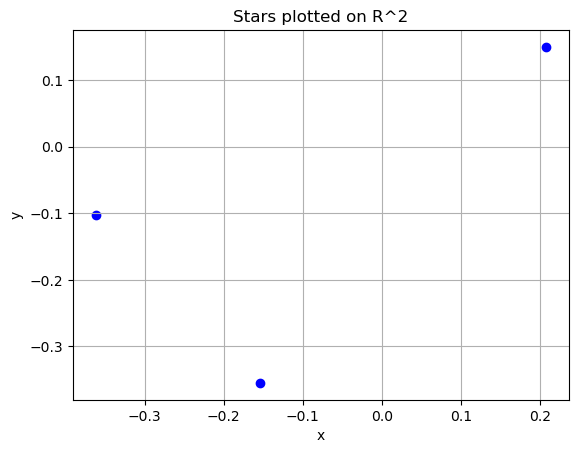

What was observed from positions we found


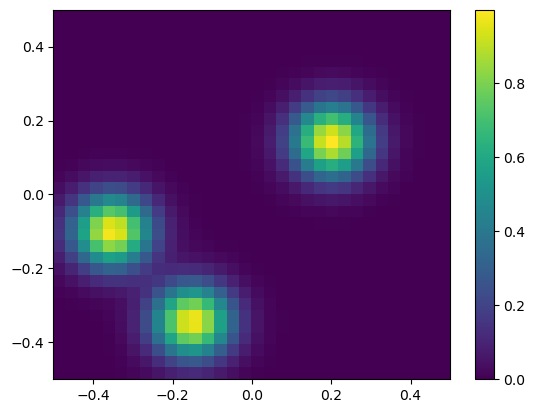

What was observed from real positions


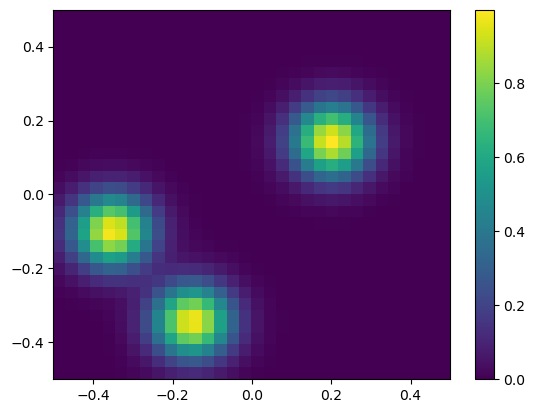

In [15]:
"""
Archived code for plotting the stars on R^2 as discrete points.
"""
def plotting_stars(Random_intial_point:np.array = X0, Delta0: float = delta_0, DeltaBar: float = np.sqrt(6),  rhoPrime: float=0.1):
    """
    usual input: random initial starting point for Trsolver, usually taken to be given by the dataset

    :param Delta0: float
    :param DeltaBar: float
    :param rhoPrime: float
    :param tol: float
    param time_limit: float
    """
    
    # x0 = X0.flatten(order='F').reshape(d*K,1) #x0 
    points = trust_region_method(Random_intial_point, DeltaBar, Delta0, rhoPrime, max_iters=30)[0]

    # Separate x and y coordinates for plotting
    x = points[0,:]
    y = points[1,:]

    # Create the scatter plot
    plt.scatter(x, y, color='blue', marker='o')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Stars plotted on R^2')
    plt.grid(True)
    plt.show()



def plotimage(X):
    """
    Plots the image of matrix X with a colorbar.
    
    Parameters:
    X : 2D array-like
        Input matrix to be plotted.
    """
    X = np.array(X)
    m, n = X.shape
    if m != n:
        print("Warning: plotimage - Input matrix is not square.")
    
    x = np.linspace(-0.5, 0.5, m)
    y = np.linspace(-0.5, 0.5, n)
    
    plt.figure()
    plt.imshow(X, extent=[x[0], x[-1], y[0], y[-1]], aspect='equal', origin='lower')
    plt.colorbar()
    plt.axis('tight')
    plt.draw()
    plt.show()


#test with X0 given for data toy
# re-initialising variables to toy data (set)
K = int(data_toy['K'])
P = data_toy['P']
X0 = data_toy['X0']
d = int(data_toy['d'])
delta_0 = data_toy['delta_0']
delta_bar = data_toy['delta_bar']
n = int(data_toy['n'])
sigma = float(data_toy['sigma'])
y = data_toy['y'].flatten(order='F').reshape((n**2,1), order="F")

solution,grad_norms5,times = trust_region_method(data_toy['X0'],delta_bar, delta_0)
print("Positions we found")
plotting_stars(data_toy['X0'])
print("What was observed from positions we found")
plotimage(bigphi(solution.reshape((2, K), order="F"),P).reshape((n,n), order="F"))
print("What was observed from real positions")
plotimage(y.reshape((n,n), order="F"))




# Question 12
Run the trust-region method several times on data.mat with different random initial points.

Since the function is non-convex, the trust-region algorithm might converge to different local minima depending on the initial point, leading to varying objective values across runs. If the stars in the dataset are well-separated (like in toy data sets), the results might be more consistent as the algorithm converges near true positions. However, for data.mat, where stars are closer and configurations more complex, we're more likely to see variability in the objective values due to multiple plausible configurations. 

The variability in the objective values across runs can be explained by the presence of multiple local minima in the function. These local minima are closely tied to the number of stars in the dataset. Specifically, the function 𝑓 tends to decrease significantly at configurations corresponding to plausible star positions. This behavior results in the function dropping near these points, creating multiple potential minima where the trust-region algorithm can converge.

/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_48905/1073894814.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K = int(data['K'])
/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_48905/1073894814.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d = int(data['d'])
/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_48905/1073894814.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(data['n'])
/var/folders/zt/35xtgbfd7292

What was observed from found positions with starting random point [[-0.42272264  0.3126515  -0.23411723 -0.16611328 -0.45908172  0.09380721
  -0.2014199   0.23985364  0.3610256  -0.09851284]
 [-0.46580525  0.3277228   0.46373861  0.04891431  0.37649063 -0.30299707
  -0.10330069 -0.02281197 -0.41004544 -0.234719  ]]


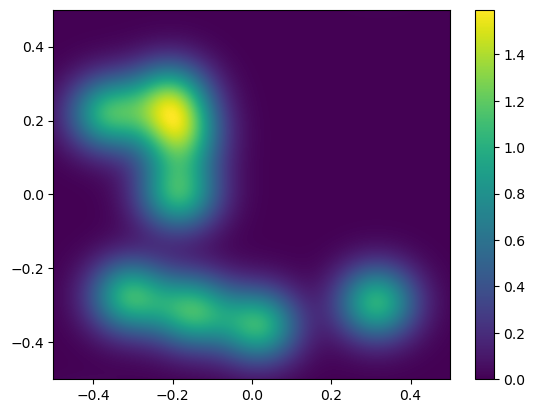

100%|██████████| 35/35 [01:02<00:00,  1.80s/it]


What was observed from found positions with starting random point [[ 0.1005105   0.48008329  0.05490512  0.13574796 -0.43166197  0.37028151
   0.39414336 -0.02451517  0.26665548  0.31464311]
 [ 0.36172172 -0.08009562  0.41019266  0.15744846  0.37845553  0.14655621
   0.10755146  0.17674369  0.09652746  0.29846048]]


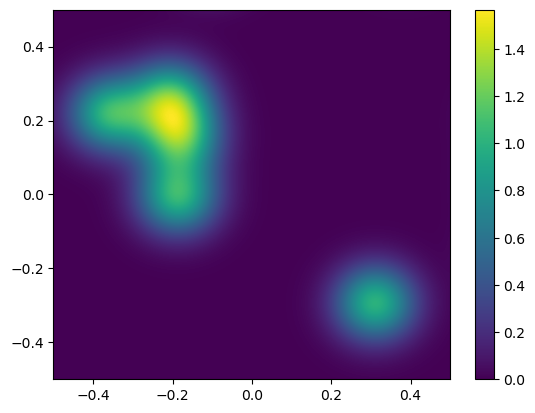

100%|██████████| 35/35 [00:58<00:00,  1.69s/it]


What was observed from found positions with starting random point [[-0.39490964  0.26769553 -0.1496831  -0.02460871 -0.25252438 -0.49080491
   0.03747388 -0.48485513  0.34225407  0.28615302]
 [-0.2254724   0.01149397  0.4800931   0.46790286 -0.08466326  0.39415731
   0.07045409 -0.35131505  0.01344999 -0.11909362]]


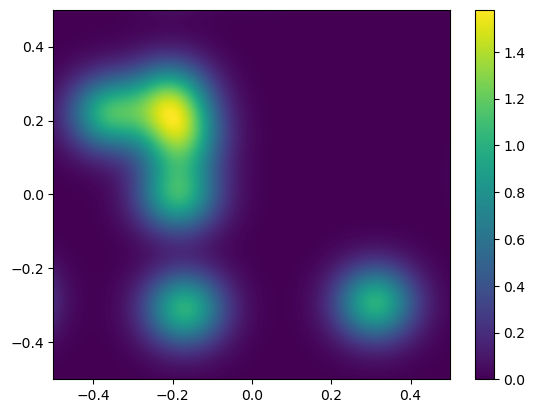

What was observed from real positions


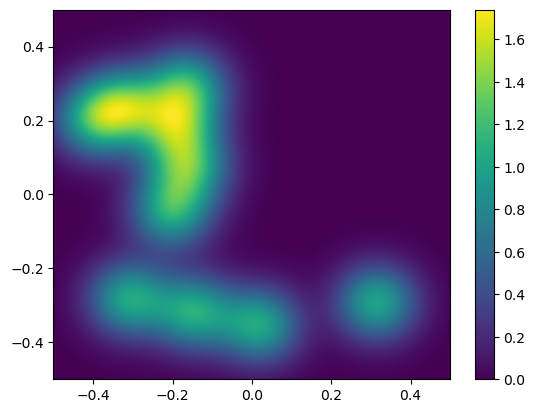

In [11]:
# re-initialising variables to data (set)
K = int(data['K'])
P = data['P']
X0 = data['X0']
d = int(data['d'])
delta_0 = data['delta_0']
delta_bar = data['delta_bar']
n = int(data['n'])
sigma = float(data['sigma'])
y = data['y'].flatten(order='F').reshape((n**2,1), order="F")

#test with random point 1
x_random1 = np.random.uniform(-0.5, 0.5, (d, K))
solution,grad_norms5,times = trust_region_method(x_random1,delta_bar, delta_0)
print(f"What was observed from found positions with starting random point {x_random1}")
plotimage(bigphi(solution.reshape((2, K), order="F"),P).reshape((n,n), order="F"))

#test with random point 2
x_random2 = np.random.uniform(-0.5, 0.5, (d, K))
solution,grad_norms5,times = trust_region_method(x_random2,delta_bar, delta_0)
print(f"What was observed from found positions with starting random point {x_random2}")
plotimage(bigphi(solution.reshape((2, K), order="F"),P).reshape((n,n), order="F"))

#test with random point 3
x_random3 = np.random.uniform(-0.5, 0.5, (d, K))
solution,grad_norms5,times = trust_region_method(x_random3,delta_bar, delta_0)
print(f"What was observed from found positions with starting random point {x_random3}")
plotimage(bigphi(solution.reshape((2, K), order="F"),P).reshape((n,n), order="F"))

print("What was observed from real positions")
plotimage(y.reshape((n,n), order="F"))


# Question 13
Run the trust-region algorithm on data.mat starting from the point x0 provided in thedataset.

Plot the norm of the gradient ∥∇f(xk)∥ as a function of k (gradient norm always on a log-scale). Do the same thing as a function of computation time.

100%|██████████| 35/35 [01:04<00:00,  1.83s/it]


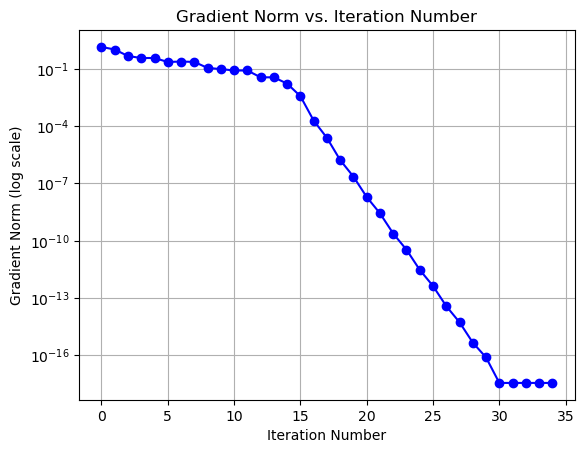

/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_48905/2298101961.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


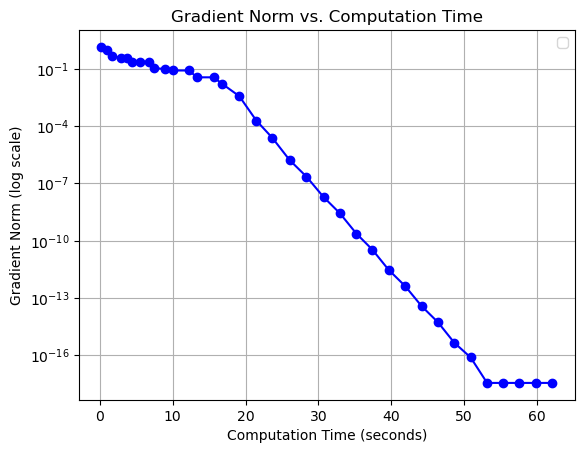

In [12]:
# plotting function for gradient norm vs iteration number
def plot_gradient_norm_iterations(gradient_norms:np.ndarray):
    plt.plot(gradient_norms, marker='o', linestyle='-', color='b')
    plt.title("Gradient Norm vs. Iteration Number") # need to maybe change this to a different title ###################
    plt.xlabel("Iteration Number")
    plt.ylabel("Gradient Norm (log scale)")
    plt.yscale('log')
    plt.grid()
    plt.show()

# plotting function for gradient norm vs iteration number
def plot_gradient_norm_time(gradient_norms1: list, time_array1: list):
    plt.plot(time_array1, gradient_norms1, marker='o', linestyle='-', color='b')
    plt.title("Gradient Norm vs. Computation Time")
    plt.xlabel("Computation Time (seconds)")
    plt.ylabel("Gradient Norm (log scale)")
    plt.yscale('log')
    plt.grid()
    plt.legend() 
    plt.show()

#test with X0 given
solution,grad_norms,time_array = trust_region_method(X0,delta_bar, delta_0)
plot_gradient_norm_iterations(grad_norms)
plot_gradient_norm_time(grad_norms,time_array)
